In [1]:
import os
import shutil
import cv2
from tqdm import tqdm

In [2]:
import os
import pandas as pd

import torch
import torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split

In [3]:
batch_size = 4

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Grayscale()
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root="../DATASETS/RIA_BY_CLASSES_CROPPED_ROTATED", transform=transform)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset sizes
print(f"Total images: {len(dataset)}, Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Total images: 2002, Train: 1601, Test: 401


In [7]:
print(dataset.classes)

['HatchBack', 'MiniVan and MicroVan', 'PickUp', 'SUV, Crossover', 'Sedan']


In [8]:
classes = (
    'HatchBack', 'MiniVan and MicroVan', 'PickUp', 'SUV, Crossover', 'Sedan'
)

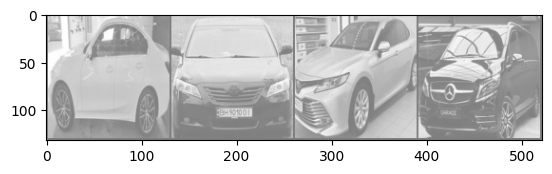

Sedan Sedan Sedan MiniVan and MicroVan


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
MODEL_NAME = "CNN"

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


if MODEL_NAME == "CNN":
  net = Net()
  print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.000812130868434906
[1,   101] loss: 0.08024791276454926
[1,   201] loss: 0.08021348345279694
[1,   301] loss: 0.08015513265132904
[1,   401] loss: 0.08021148663759231
[2,     1] loss: 0.0007756268382072449
[2,   101] loss: 0.0798501450419426
[2,   201] loss: 0.07927990508079528
[2,   301] loss: 0.07879404824972153
[2,   401] loss: 0.07941165679693223
[3,     1] loss: 0.0007483505010604858
[3,   101] loss: 0.07758703738451005
[3,   201] loss: 0.07772784012556076
[3,   301] loss: 0.07695678120851517
[3,   401] loss: 0.077999909222126
[4,     1] loss: 0.0007142950296401977
[4,   101] loss: 0.0760157369375229
[4,   201] loss: 0.07817110389471055
[4,   301] loss: 0.07435775974392891
[4,   401] loss: 0.0752401897907257
[5,     1] loss: 0.0007081716656684875
[5,   101] loss: 0.07292710500955582
[5,   201] loss: 0.07472803083062173
[5,   301] loss: 0.07320053574442864
[5,   401] loss: 0.07529182451963425
Finished Training


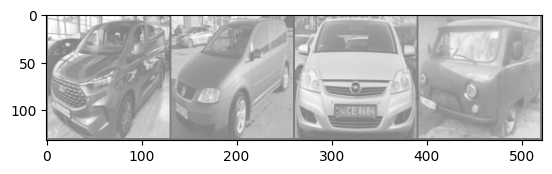

GroundTruth:  MiniVan and MicroVan MiniVan and MicroVan MiniVan and MicroVan PickUp


In [13]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: HatchBack is 1.2 %
Accuracy for class: MiniVan and MicroVan is 47.7 %
Accuracy for class: PickUp is 6.9 %
Accuracy for class: SUV, Crossover is 47.1 %
Accuracy for class: Sedan is 53.3 %
